# ISLES'22 Ensemble Strategies with MONAI

This notebook implements bagging, boosting, and stacking ensembles for ischemic stroke lesion segmentation on the ISLES'22 pre-processed dataset using MONAI. It assumes that the pre-processed data has been downloaded locally (see the setup cell below for expected directory structure).


## 1. Environment Setup

- Python 3.10+
- `torch` 2.0+ with CUDA if available
- `monai` 1.3+
- `numpy`, `pandas`, `matplotlib`, `scikit-learn`
- Optional: `tqdm`, `tensorboard`

Expected directory layout after downloading the ISLES'22 pre-processed data from Google Drive:

```
/data/isles22/
    imagesTr/
        case_0001.nii.gz
        ...
    labelsTr/
        case_0001_seg.nii.gz
        ...
    imagesVal/
    labelsVal/
```

Update `DATA_ROOT` in the configuration cell if your paths differ. If the dataset is not present, the notebook can be run in dry-run mode using a synthetic dataset for debugging.


In [33]:
# If running in a fresh environment, uncomment the following line to install dependencies.
!pip install --upgrade pip
!pip install "torch>=2.0" "monai-weekly[nibabel,tqdm,ignite]" scikit-learn pandas matplotlib


In [34]:
import os
import json
import warnings
from dataclasses import dataclass, field
from pathlib import Path
from typing import Dict, List, Optional, Sequence, Tuple, Union

import numpy as np
import matplotlib.pyplot as plt
import torch
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.transforms import (
    Activationsd,
    AsDiscreted,
    EnsureChannelFirstd,
    EnsureTyped,
    Compose,
    Invertd,
    LoadImage,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    RandAffined,
    RandZoomd,
    RandFlipd,
    RandSpatialCropd,
    SaveImaged,
    ScaleIntensityRanged,
)
from monai.utils import set_determinism
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

print_config()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


MONAI version: 1.6.dev2544
Numpy version: 2.0.2
Pytorch version: 2.8.0+cu126
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: f910be902091ce9efdc2928e1eb473fd607bfeb9
MONAI __file__: /usr/local/lib/python3.12/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.16.3
Pillow version: 11.3.0
Tensorboard version: 2.19.0
gdown version: 5.2.0
TorchVision version: 0.23.0+cu126
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.57.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.htm

In [35]:
@dataclass
class ExperimentConfig:
    data_root: Path = Path("")
    images_subdir: str = "imagesTr"
    labels_subdir: str = "labelsTr"
    val_images_subdir: Optional[str] = "imagesVal"
    val_labels_subdir: Optional[str] = "labelsVal"
    gdrive_folder_id: str = "1wHf2yowkngPFlQwJyGdNs2i7fJ0hj_jL"
    case_glob: str = "sub-strokecase*"
    drive_session_dir: str = "ses-0001"
    modality_suffixes: Tuple[Union[str, Tuple[str, ...]], ...] = (
        ("adc_normalized", "adc_n4"),
        ("dwi_normalized", "dwi_n4"),
        ("flair_normalized", "flair_n4"),
    )
    label_suffix: str = "lesion-msk"
    cache_rate: float = 0.2
    num_workers: int = 4
    roi_size: Tuple[int, int, int] = (128, 128, 64)
    batch_size: int = 2
    base_lr: float = 1e-4
    max_epochs: int = 120
    patience: int = 30
    n_bagging_models: int = 5
    boosting_rounds: int = 4
    stacking_meta_epochs: int = 80
    amp: bool = True
    num_classes: int = 2
    seed: int = 42
    validation_split: float = 0.2
    synthetic_samples: int = 10  # used for dry-run mode when data is unavailable
    auto_download: bool = False
    download_root: Path = Path("")

    in_channels: int = field(init=False)

    def __post_init__(self):
        object.__setattr__(
            self,
            "in_channels",
            max(1, len(self.modality_suffixes)),
        )


cfg = ExperimentConfig()
set_determinism(seed=cfg.seed)


In [36]:
def check_dataset_layout(cfg: ExperimentConfig) -> str:
    image_dir = cfg.data_root / cfg.images_subdir
    label_dir = cfg.data_root / cfg.labels_subdir
    if image_dir.exists() and label_dir.exists():
        print(f"Found dataset at {cfg.data_root} using MONAI baseline layout.")
        return "classic"

    drive_pattern = f"**/{cfg.case_glob}"
    drive_cases = [p for p in cfg.data_root.glob(drive_pattern) if p.is_dir()]
    if drive_cases:
        unique_names = sorted({p.name for p in drive_cases})
        print(
            f"Found {len(unique_names)} cases matching '{cfg.case_glob}' under {cfg.data_root}."
        )
        return "drive"

    print(
        "Dataset not found. Enable dry-run mode by generating synthetic data or update cfg.data_root."
    )
    return "none"


dataset_layout = check_dataset_layout(cfg)
data_available = dataset_layout != "none"


Dataset not found. Enable dry-run mode by generating synthetic data or update cfg.data_root.


In [37]:
def maybe_download_drive_dataset(cfg: ExperimentConfig, dataset_layout: str) -> str:
    if dataset_layout != "none" or not cfg.auto_download:
        return dataset_layout

    try:
        import gdown  # type: ignore
    except ImportError:  # pragma: no cover - dependency installation
        import subprocess
        import sys

        print("Installing gdown for Google Drive downloads...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown"])
        import gdown  # type: ignore

    cfg.download_root.mkdir(parents=True, exist_ok=True)
    cfg.data_root = cfg.download_root
    url = f"https://drive.google.com/drive/folders/{cfg.gdrive_folder_id}"
    print(f"Downloading Google Drive folder from {url} to {cfg.download_root} ...")
    try:
        gdown.download_folder(
            url=url,
            output=str(cfg.download_root),
            quiet=False,
            use_cookies=False,
            remaining_ok=True,
        )
    except Exception as exc:  # pragma: no cover - network failure logging
        print(
            f"Failed to download dataset automatically: {exc}. "
            "Please download manually or update cfg.data_root."
        )
        return dataset_layout

    return check_dataset_layout(cfg)


if dataset_layout == "none" and cfg.auto_download:
    dataset_layout = maybe_download_drive_dataset(cfg, dataset_layout)
    data_available = dataset_layout != "none"


### Data Access

- Download the 62-case pre-processed ISLES'22 dataset from the public Google Drive folder (ID `1wHf2yowkngPFlQwJyGdNs2i7fJ0hj_jL`) so that each case lives under `sub-strokecaseXXXX/ses-0001`.
- Update `cfg.data_root` if the dataset resides in a different directory. By default the notebook expects the folder under `./data/isles22`.
- Set `cfg.auto_download = True` to let the notebook fetch the Google Drive folder automatically with `gdown.download_folder` (files are saved in `cfg.download_root`).
- The loader pairs the modalities `_adc_normalized` (or `_adc_n4`), `_dwi_normalized` (or `_dwi_n4`), `_flair_normalized` (or `_flair_n4`) with the lesion mask `_lesion-msk` for each case.


In [38]:
def _format_suffix(suffix: Union[str, Tuple[str, ...]]) -> str:
    if isinstance(suffix, str):
        return suffix
    return " / ".join(suffix)


def _resolve_path(source_dir: Path, suffix: Union[str, Tuple[str, ...]]) -> Optional[Path]:
    candidates = (suffix,) if isinstance(suffix, str) else suffix
    for candidate in candidates:
        for extension in ("nii", "nii.gz", "npy"):
            pattern = f"*_{candidate}.{extension}"
            matches = sorted(source_dir.glob(pattern))
            if matches:
                return matches[0]
    return None


def discover_drive_cases(cfg: ExperimentConfig) -> List[Dict[str, Union[str, List[str]]]]:
    pattern = f"**/{cfg.case_glob}"
    case_dirs = [p for p in cfg.data_root.glob(pattern) if p.is_dir()]
    cases: Dict[str, Dict[str, Union[str, List[str]]]] = {}
    for case_dir in sorted(case_dirs):
        case_name = case_dir.name
        if case_name in cases:
            continue
        session_dir = case_dir / cfg.drive_session_dir
        candidate_dir = session_dir if session_dir.is_dir() else case_dir
        label_path = _resolve_path(candidate_dir, cfg.label_suffix)
        if label_path is None:
            warnings.warn(f"Skipping {case_name}: missing label '{cfg.label_suffix}'.")
            continue
        modality_paths: List[str] = []
        missing_suffixes: List[str] = []
        for suffix in cfg.modality_suffixes:
            modality_path = _resolve_path(candidate_dir, suffix)
            if modality_path is None:
                missing_suffixes.append(_format_suffix(suffix))
            else:
                modality_paths.append(str(modality_path))
        if missing_suffixes:
            warnings.warn(
                f"Skipping {case_name}: missing modalities [{', '.join(missing_suffixes)}]."
            )
            continue
        cases[case_name] = {
            "case_id": case_name,
            "image": modality_paths,
            "label": str(label_path),
        }
    return [cases[name] for name in sorted(cases.keys())]


def build_file_lists(cfg: ExperimentConfig) -> Tuple[List[Dict[str, Union[str, List[str]]]], List[Dict[str, Union[str, List[str]]]]]:
    if not data_available:
        print("Running in synthetic mode with random tensors for debugging.")
        temp_dir = Path("./synthetic_isles22")
        temp_dir.mkdir(exist_ok=True)
        np.random.seed(cfg.seed)
        samples = []
        for idx in range(cfg.synthetic_samples):
            image_path = temp_dir / f"image_{idx}.npy"
            label_path = temp_dir / f"label_{idx}.npy"
            np.save(
                image_path,
                np.random.rand(cfg.in_channels, *cfg.roi_size).astype(np.float32),
            )
            np.save(
                label_path,
                (np.random.rand(1, *cfg.roi_size) > 0.8).astype(np.uint8),
            )
            samples.append(
                {"case_id": f"synthetic_{idx}", "image": str(image_path), "label": str(label_path)}
            )
        train_samples, val_samples = train_test_split(
            samples, test_size=cfg.validation_split, random_state=cfg.seed
        )
        return train_samples, val_samples

    if dataset_layout == "classic":
        image_dir = cfg.data_root / cfg.images_subdir
        label_dir = cfg.data_root / cfg.labels_subdir
        image_files = sorted([p for p in image_dir.glob("*.nii*")])
        label_files = sorted([p for p in label_dir.glob("*.nii*")])
        assert len(image_files) == len(label_files), "Mismatch between images and labels"
        data = [
            {"case_id": i.stem, "image": str(i), "label": str(l)}
            for i, l in zip(image_files, label_files)
        ]
    else:
        data = discover_drive_cases(cfg)
        if not data:
            raise FileNotFoundError(
                f"No cases discovered under {cfg.data_root}. Verify the Google Drive download."
            )

    if dataset_layout == "classic" and cfg.val_images_subdir and cfg.val_labels_subdir:
        val_images = sorted((cfg.data_root / cfg.val_images_subdir).glob("*.nii*"))
        val_labels = sorted((cfg.data_root / cfg.val_labels_subdir).glob("*.nii*"))
        if val_images and val_labels:
            val_data = [
                {"case_id": i.stem, "image": str(i), "label": str(l)}
                for i, l in zip(val_images, val_labels)
            ]
            return data, val_data

    train_data, val_data = train_test_split(
        data, test_size=cfg.validation_split, random_state=cfg.seed
    )
    return train_data, val_data


train_files, val_files = build_file_lists(cfg)
print(f"Train samples: {len(train_files)}, Validation samples: {len(val_files)}")


Running in synthetic mode with random tensors for debugging.
Train samples: 8, Validation samples: 2


In [39]:
class LoadVolume(MapTransform):
    """Load multi-modal NIfTI or NumPy volumes into memory."""

    def __init__(self, keys: Sequence[str]):
        super().__init__(keys)
        self.image_loader = LoadImage(image_only=True)

    def _load_single(self, path: Union[str, Path]) -> np.ndarray:
        path = Path(path)
        if str(path).endswith(".npy"):
            array = np.load(path)
        else:
            array = self.image_loader(path)
            array = np.asarray(array)
        if array.ndim == 3:
            array = np.expand_dims(array, axis=0)
        return array

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            value = d[key]
            if isinstance(value, (list, tuple)):
                arrays = [self._load_single(v) for v in value]
                d[key] = np.concatenate(arrays, axis=0)
            else:
                d[key] = self._load_single(value)
        return d


In [40]:
def get_transforms(cfg: ExperimentConfig, dataset_layout: str, augment: bool = True):
    load = LoadVolume(keys=["image", "label"])
    common = [
        EnsureChannelFirstd(keys=["image", "label"], channel_dim=0),
        EnsureTyped(keys=["image", "label"], dtype=torch.float32),
    ]
    if dataset_layout == "drive":
        intensity = NormalizeIntensityd(keys=["image"], channel_wise=True)
    elif data_available:
        intensity = ScaleIntensityRanged(
            keys=["image"],
            a_min=-200,
            a_max=200,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        )
    else:
        # For synthetic data or when data is not available, assume image is already in a reasonable range (e.g., 0-1)
        intensity = ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=1.0, b_min=0.0, b_max=1.0)

    # Ensure label is treated as discrete values (0 or 1) and not scaled
    label_transforms = [EnsureTyped(keys="label", dtype=torch.long)] # Change dtype to long for labels

    aug: List = []
    if augment:
        aug.extend(
            [
                RandSpatialCropd(keys=["image", "label"], roi_size=cfg.roi_size, random_size=False),
                RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
                RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
                RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
                RandZoomd(keys=["image", "label"], prob=0.2, min_zoom=0.9, max_zoom=1.1),
                RandAffined(
                    keys=["image", "label"],
                    prob=0.15,
                    translate_range=[10, 10, 5],
                    rotate_range=[np.pi / 18] * 3,
                    padding_mode="border",
                ),
            ]
        )
    else:
        aug.append(
            RandSpatialCropd(
                keys=["image", "label"], roi_size=cfg.roi_size, random_size=False, random_center=False
            )
        )

    post = [EnsureTyped(keys=["image", "label"], dtype=torch.float32)] # Keep image as float32

    return Compose([load, *common, intensity, *aug, *label_transforms, *post]) # Add label_transforms


def create_datasets(cfg: ExperimentConfig, dataset_layout: str):
    train_transforms = get_transforms(cfg, dataset_layout, augment=True)
    val_transforms = get_transforms(cfg, dataset_layout, augment=False)

    train_ds = CacheDataset(train_files, transform=train_transforms, cache_rate=cfg.cache_rate)
    val_ds = CacheDataset(val_files, transform=val_transforms, cache_rate=cfg.cache_rate)
    return train_ds, val_ds


def create_dataloader(dataset, batch_size, shuffle=True, sample_weights=None):
    if sample_weights is not None:
        sampler = torch.utils.data.WeightedRandomSampler(
            weights=torch.tensor(sample_weights, dtype=torch.double),
            num_samples=len(sample_weights),
            replacement=True,
        )
        shuffle = False
    else:
        sampler = None

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle and sampler is None,
        sampler=sampler,
        num_workers=cfg.num_workers,
        pin_memory=torch.cuda.is_available(),
    )


train_ds, val_ds = create_datasets(cfg, dataset_layout)
train_loader = create_dataloader(train_ds, cfg.batch_size, shuffle=True)
val_loader = create_dataloader(val_ds, batch_size=1, shuffle=False)

Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 13.55it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [41]:
# Redefine ExperimentConfig and cfg to ensure they are available
@dataclass
class ExperimentConfig:
    data_root: Path = Path("")
    images_subdir: str = "imagesTr"
    labels_subdir: str = "labelsTr"
    val_images_subdir: Optional[str] = "imagesVal"
    val_labels_subdir: Optional[str] = "labelsVal"
    gdrive_folder_id: str = "1wHf2yowkngPFlQwJyGdNs2i7fJ0hj_jL"
    case_glob: str = "sub-strokecase*"
    drive_session_dir: str = "ses-0001"
    modality_suffixes: Tuple[Union[str, Tuple[str, ...]], ...] = (
        ("adc_normalized", "adc_n4"),
        ("dwi_normalized", "dwi_n4"),
        ("flair_normalized", "flair_n4"),
    )
    label_suffix: str = "lesion-msk"
    cache_rate: float = 0.2
    num_workers: int = 4
    roi_size: Tuple[int, int, int] = (128, 128, 64)
    batch_size: int = 2
    base_lr: float = 1e-4
    max_epochs: int = 120
    patience: int = 30
    n_bagging_models: int = 5
    boosting_rounds: int = 4
    stacking_meta_epochs: int = 80
    amp: bool = True
    num_classes: int = 2
    seed: int = 42
    validation_split: float = 0.2
    synthetic_samples: int = 10  # used for dry-run mode when data is unavailable
    auto_download: bool = False
    download_root: Path = Path("./data/isles22")

    in_channels: int = field(init=False)

    def __post_init__(self):
        object.__setattr__(
            self,
            "in_channels",
            max(1, len(self.modality_suffixes)),
        )

cfg = ExperimentConfig()
set_determinism(seed=cfg.seed)

# Redefine check_dataset_layout and maybe_download_drive_dataset
def check_dataset_layout(cfg: ExperimentConfig) -> str:
    image_dir = cfg.data_root / cfg.images_subdir
    label_dir = cfg.data_root / cfg.labels_subdir
    if image_dir.exists() and label_dir.exists():
        print(f"Found dataset at {cfg.data_root} using MONAI baseline layout.")
        return "classic"

    drive_pattern = f"**/{cfg.case_glob}"
    drive_cases = [p for p in cfg.data_root.glob(drive_pattern) if p.is_dir()]
    if drive_cases:
        unique_names = sorted({p.name for p in drive_cases})
        print(
            f"Found {len(unique_names)} cases matching '{cfg.case_glob}' under {cfg.data_root}."
        )
        return "drive"

    print(
        "Dataset not found. Enable dry-run mode by generating synthetic data or update cfg.data_root."
    )
    return "none"


def maybe_download_drive_dataset(cfg: ExperimentConfig, dataset_layout: str) -> str:
    if dataset_layout != "none" or not cfg.auto_download:
        return dataset_layout

    try:
        import gdown  # type: ignore
    except ImportError:  # pragma: no cover - dependency installation
        import subprocess
        import sys

        print("Installing gdown for Google Drive downloads...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown"])
        import gdown  # type: ignore

    cfg.download_root.mkdir(parents=True, exist_ok=True)
    cfg.data_root = cfg.download_root
    url = f"https://drive.google.com/drive/folders/{cfg.gdrive_folder_id}"
    print(f"Downloading Google Drive folder from {url} to {cfg.download_root} ...")
    try:
        gdown.download_folder(
            url=url,
            output=str(cfg.download_root),
            quiet=False,
            use_cookies=False,
            remaining_ok=True,
        )
    except Exception as exc:  # pragma: no cover - network failure logging
        print(
            f"Failed to download dataset automatically: {exc}. "
            "Please download manually or update cfg.data_root."
        )
        return dataset_layout

    return check_dataset_layout(cfg)

dataset_layout = check_dataset_layout(cfg)
data_available = dataset_layout != "none"

if dataset_layout == "none" and cfg.auto_download:
    dataset_layout = maybe_download_drive_dataset(cfg, dataset_layout)
    data_available = dataset_layout != "none"


# Redefine data loading and file list building functions
def _format_suffix(suffix: Union[str, Tuple[str, ...]]) -> str:
    if isinstance(suffix, str):
        return suffix
    return " / ".join(suffix)


def _resolve_path(source_dir: Path, suffix: Union[str, Tuple[str, ...]]) -> Optional[Path]:
    candidates = (suffix,) if isinstance(suffix, str) else suffix
    for candidate in candidates:
        for extension in ("nii", "nii.gz", "npy"):
            pattern = f"*_{candidate}.{extension}"
            matches = sorted(source_dir.glob(pattern))
            if matches:
                return matches[0]
    return None


def discover_drive_cases(cfg: ExperimentConfig) -> List[Dict[str, Union[str, List[str]]]]:
    pattern = f"**/{cfg.case_glob}"
    case_dirs = [p for p in cfg.data_root.glob(pattern) if p.is_dir()]
    cases: Dict[str, Dict[str, Union[str, List[str]]]] = {}
    for case_dir in sorted(case_dirs):
        case_name = case_dir.name
        if case_name in cases:
            continue
        session_dir = case_dir / cfg.drive_session_dir
        candidate_dir = session_dir if session_dir.is_dir() else case_dir
        label_path = _resolve_path(candidate_dir, cfg.label_suffix)
        if label_path is None:
            warnings.warn(f"Skipping {case_name}: missing label '{cfg.label_suffix}'.")
            continue
        modality_paths: List[str] = []
        missing_suffixes: List[str] = []
        for suffix in cfg.modality_suffixes:
            modality_path = _resolve_path(candidate_dir, suffix)
            if modality_path is None:
                missing_suffixes.append(_format_suffix(suffix))
            else:
                modality_paths.append(str(modality_path))
        if missing_suffixes:
            warnings.warn(
                f"Skipping {case_name}: missing modalities [{', '.join(missing_suffixes)}]."
            )
            continue
        cases[case_name] = {
            "case_id": case_name,
            "image": modality_paths,
            "label": str(label_path),
        }
    return [cases[name] for name in sorted(cases.keys())]


def build_file_lists(cfg: ExperimentConfig) -> Tuple[List[Dict[str, Union[str, List[str]]]], List[Dict[str, Union[str, List[str]]]]]:
    if not data_available:
        print("Running in synthetic mode with random tensors for debugging.")
        temp_dir = Path("./synthetic_isles22")
        temp_dir.mkdir(exist_ok=True)
        np.random.seed(cfg.seed)
        samples = []
        for idx in range(cfg.synthetic_samples):
            image_path = temp_dir / f"image_{idx}.npy"
            label_path = temp_dir / f"label_{idx}.npy"
            np.save(
                image_path,
                np.random.rand(cfg.in_channels, *cfg.roi_size).astype(np.float32),
            )
            np.save(
                label_path,
                (np.random.rand(1, *cfg.roi_size) > 0.8).astype(np.uint8),
            )
            samples.append(
                {"case_id": f"synthetic_{idx}", "image": str(image_path), "label": str(label_path)}
            )
        train_samples, val_samples = train_test_split(
            samples, test_size=cfg.validation_split, random_state=cfg.seed
        )
        return train_samples, val_samples

    if dataset_layout == "classic":
        image_dir = cfg.data_root / cfg.images_subdir
        label_dir = cfg.data_root / cfg.labels_subdir
        image_files = sorted([p for p in image_dir.glob("*.nii*")])
        label_files = sorted([p for p in label_dir.glob("*.nii*")])
        assert len(image_files) == len(label_files), "Mismatch between images and labels"
        data = [
            {"case_id": i.stem, "image": str(i), "label": str(l)}
            for i, l in zip(image_files, label_files)
        ]
    else:
        data = discover_drive_cases(cfg)
        if not data:
            raise FileNotFoundError(
                f"No cases discovered under {cfg.data_root}. Verify the Google Drive download."
            )

    if dataset_layout == "classic" and cfg.val_images_subdir and cfg.val_labels_subdir:
        val_images = sorted((cfg.data_root / cfg.val_images_subdir).glob("*.nii*"))
        val_labels = sorted((cfg.data_root / cfg.val_labels_subdir).glob("*.nii*"))
        if val_images and val_labels:
            val_data = [
                {"case_id": i.stem, "image": str(i), "label": str(l)}
                for i, l in zip(val_images, val_labels)
            ]
            return data, val_data

    train_data, val_data = train_test_split(
        data, test_size=cfg.validation_split, random_state=cfg.seed
    )
    return train_data, val_data


train_files, val_files = build_file_lists(cfg)
print(f"Train samples: {len(train_files)}, Validation samples: {len(val_files)}")

Dataset not found. Enable dry-run mode by generating synthetic data or update cfg.data_root.
Running in synthetic mode with random tensors for debugging.
Train samples: 8, Validation samples: 2


In [42]:
# Redefine data transforms and dataloaders
class LoadVolume(MapTransform):
    """Load multi-modal NIfTI or NumPy volumes into memory."""

    def __init__(self, keys: Sequence[str]):
        super().__init__(keys)
        self.image_loader = LoadImage(image_only=True)

    def _load_single(self, path: Union[str, Path]) -> np.ndarray:
        path = Path(path)
        if str(path).endswith(".npy"):
            array = np.load(path)
        else:
            array = self.image_loader(path)
            array = np.asarray(array)
        if array.ndim == 3:
            array = np.expand_dims(array, axis=0)
        return array

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            value = d[key]
            if isinstance(value, (list, tuple)):
                arrays = [self._load_single(v) for v in value]
                d[key] = np.concatenate(arrays, axis=0)
            else:
                d[key] = self._load_single(value)
        return d


def get_transforms(cfg: ExperimentConfig, dataset_layout: str, augment: bool = True):
    load = LoadVolume(keys=["image", "label"])
    common = [
        EnsureChannelFirstd(keys=["image", "label"], channel_dim=0),
        EnsureTyped(keys=["image", "label"], dtype=torch.float32),
    ]
    if dataset_layout == "drive":
        intensity = NormalizeIntensityd(keys=["image"], channel_wise=True)
    elif data_available:
        intensity = ScaleIntensityRanged(
            keys=["image"],
            a_min=-200,
            a_max=200,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        )
    else:
        # For synthetic data or when data is not available, assume image is already in a reasonable range (e.g., 0-1)
        intensity = ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=1.0, b_min=0.0, b_max=1.0)

    # Ensure label is treated as discrete values (0 or 1) and not scaled
    label_transforms = [EnsureTyped(keys="label", dtype=torch.long)] # Change dtype to long for labels

    aug: List = []
    if augment:
        aug.extend(
            [
                RandSpatialCropd(keys=["image", "label"], roi_size=cfg.roi_size, random_size=False),
                RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
                RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
                RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
                RandZoomd(keys=["image", "label"], prob=0.2, min_zoom=0.9, max_zoom=1.1),
                RandAffined(
                    keys=["image", "label"],
                    prob=0.15,
                    translate_range=[10, 10, 5],
                    rotate_range=[np.pi / 18] * 3,
                    padding_mode="border",
                ),
            ]
        )
    else:
        aug.append(
            RandSpatialCropd(
                keys=["image", "label"], roi_size=cfg.roi_size, random_size=False, random_center=False
            )
        )

    post = [EnsureTyped(keys=["image", "label"], dtype=torch.float32)] # Keep image as float32

    return Compose([load, *common, intensity, *aug, *label_transforms, *post]) # Add label_transforms


def create_datasets(cfg: ExperimentConfig, dataset_layout: str):
    train_transforms = get_transforms(cfg, dataset_layout, augment=True)
    val_transforms = get_transforms(cfg, dataset_layout, augment=False)

    train_ds = CacheDataset(train_files, transform=train_transforms, cache_rate=cfg.cache_rate)
    val_ds = CacheDataset(val_files, transform=val_transforms, cache_rate=cfg.cache_rate)
    return train_ds, val_ds


def create_dataloader(dataset, batch_size, shuffle=True, sample_weights=None):
    if sample_weights is not None:
        sampler = torch.utils.data.WeightedRandomSampler(
            weights=torch.tensor(sample_weights, dtype=torch.double),
            num_samples=len(sample_weights),
            replacement=True,
        )
        shuffle = False
    else:
        sampler = None

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle and sampler is None,
        sampler=sampler,
        num_workers=cfg.num_workers,
        pin_memory=torch.cuda.is_available(),
    )


train_ds, val_ds = create_datasets(cfg, dataset_layout)
train_loader = create_dataloader(train_ds, cfg.batch_size, shuffle=True)
val_loader = create_dataloader(val_ds, batch_size=1, shuffle=False)

Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 25.63it/s]


In [43]:
# Redefine visualization function
def extract_slice(volume: np.ndarray, axis: str, index: Optional[int] = None) -> Tuple[np.ndarray, int]:
    axis = axis.lower()
    axis_map = {"x": 0, "y": 1, "z": 2}
    if axis not in axis_map:
        raise ValueError(f"Axis must be one of {tuple(axis_map.keys())}, got '{axis}'.")
    axis_idx = axis_map[axis]
    if volume.ndim != 3:
        raise ValueError(f"Expected a 3D volume, got shape {volume.shape}.")
    num_slices = volume.shape[axis_idx]
    if num_slices == 0:
        raise ValueError("Cannot extract a slice from an empty volume.")
    if index is None:
        index = num_slices // 2
    index = int(np.clip(index, 0, num_slices - 1))
    if axis_idx == 0:
        return volume[index, :, :], index
    if axis_idx == 1:
        return volume[:, index, :], index
    return volume[:, :, index], index


def visualize_prediction(
    dataset,
    predict_fn,
    sample_index: int = 0,
    axis: str = "z",
    slice_index: Optional[int] = None,
    figsize: Tuple[int, int] = (16, 4),
):
    """Visualize an image slice alongside ground-truth and predicted masks."""
    if len(dataset) == 0:
        raise ValueError("Dataset is empty; nothing to visualize.")

    sample = dataset[sample_index % len(dataset)]
    image = sample["image"]
    label = sample["label"]

    if torch.is_tensor(image):
        image_np = image.detach().cpu().numpy()
        batch_image = image.unsqueeze(0).to(device)
    else:
        image_np = np.asarray(image)
        if image_np.ndim == 3:
            image_np = image_np[np.newaxis, ...]
        batch_image = torch.from_numpy(image_np).unsqueeze(0).float().to(device)

    if torch.is_tensor(label):
        label_np = label.detach().cpu().numpy()
    else:
        label_np = np.asarray(label)
        if label_np.ndim == 3:
            label_np = label_np[np.newaxis, ...]

    image_volume = image_np[0] if image_np.ndim >= 4 else image_np
    label_volume = label_np[0] if label_np.ndim >= 4 else label_np

    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=cfg.amp):
            preds = predict_fn(batch_image)
    if isinstance(preds, np.ndarray):
        preds = torch.from_numpy(preds)
    if not torch.is_tensor(preds):
        preds = torch.tensor(preds)
    preds = preds.to(device)

    if preds.shape[1] == 1:
        probs = torch.sigmoid(preds)
        pred_mask = (probs > 0.5).long()
    else:
        if preds.min().item() < 0.0 or preds.max().item() > 1.0:
            probs = torch.softmax(preds, dim=1)
        else:
            probs = preds
        pred_mask = torch.argmax(probs, dim=1)

    probs_np = probs.squeeze(0).detach().cpu().numpy()
    pred_np = pred_mask.squeeze(0).cpu().numpy()

    slice_image, resolved_idx = extract_slice(image_volume, axis, slice_index)
    slice_label, _ = extract_slice(label_volume, axis, resolved_idx)
    if probs_np.ndim == 4 and probs_np.shape[0] > 1:
        positive_probs = probs_np[1]
    else:
        positive_probs = probs_np if probs_np.ndim == 3 else probs_np.squeeze()
    slice_pred, _ = extract_slice(pred_np, axis, resolved_idx)
    slice_prob, _ = extract_slice(positive_probs, axis, resolved_idx)

    fig, axes = plt.subplots(1, 4, figsize=figsize)
    axes[0].imshow(slice_image, cmap="gray")
    axes[0].set_title(f"Image (axis {axis.upper()} @ {resolved_idx})")
    axes[1].imshow(slice_label, cmap="Greens")
    axes[1].set_title("Ground Truth Mask")
    axes[2].imshow(slice_pred, cmap="Purples")
    axes[2].set_title("Predicted Mask")
    im = axes[3].imshow(slice_prob, cmap="magma")
    axes[3].set_title("Prediction Probability")
    fig.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    return fig

No trained ensemble available; using a randomly initialised UNet for visualization.


/tmp/ipython-input-793892184.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.amp):
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


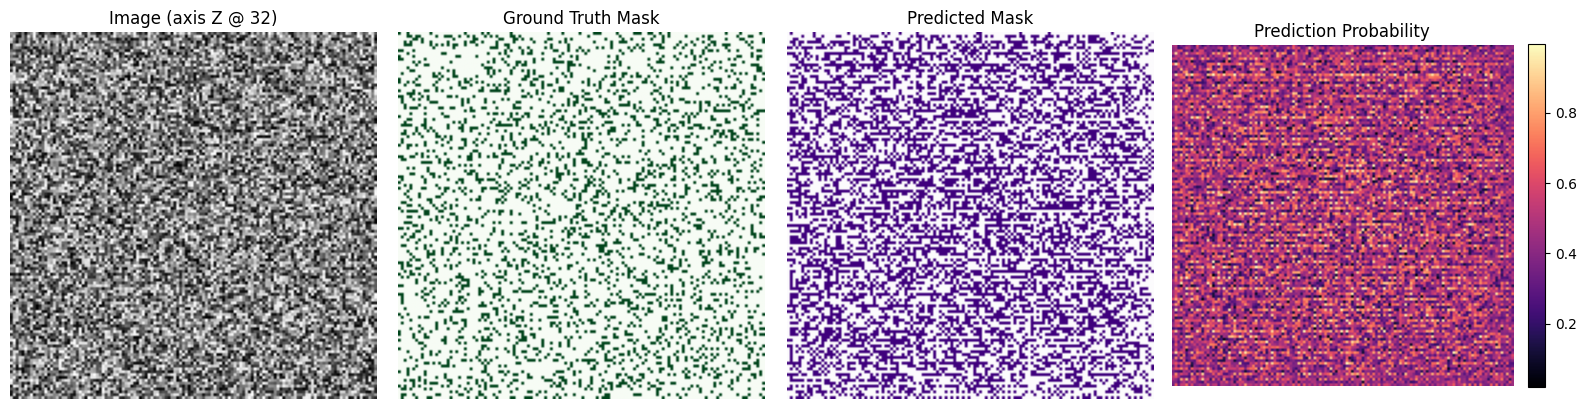

In [44]:
def create_unet(cfg: ExperimentConfig) -> nn.Module:
    model = UNet(
        spatial_dims=3,
        in_channels=cfg.in_channels,
        out_channels=cfg.num_classes,
        channels=(32, 64, 128, 256, 512),
        strides=(2, 2, 2, 2),
        num_res_units=3,
        norm="instance",
        dropout=0.2,
    )
    return model.to(device)

# Redefine visualization control cell
VISUALIZE_SAMPLE = True
SAMPLE_INDEX = 1
SLICE_AXIS = "z"
SLICE_INDEX = 32  # Fixed slice for reproducibility

if VISUALIZE_SAMPLE:
    dataset_for_vis = val_ds if len(val_ds) > 0 else train_ds
    if len(dataset_for_vis) == 0:
        raise ValueError("Both training and validation datasets are empty; nothing to visualize.")

    def build_visualization_predictor():
        bagging = globals().get("bagging_models", [])
        boosting = globals().get("boosting_models", [])
        boosting_alphas = globals().get("boosting_alphas")
        meta_model = globals().get("meta_model")

        if bagging and meta_model is not None:
            print("Using stacking ensemble for visualization.")
            return lambda imgs: stacking_inference(bagging, meta_model, imgs)
        if bagging:
            print("Using bagging ensemble for visualization.")
            return lambda imgs: bagging_inference(bagging, imgs)
        if boosting and boosting_alphas is not None:
            print("Using boosting ensemble for visualization.")
            return lambda imgs: boosting_inference(boosting, boosting_alphas, imgs)

        print("No trained ensemble available; using a randomly initialised UNet for visualization.")
        fallback_model = create_unet(cfg)
        fallback_model.eval()

        def _fallback_predict(imgs: torch.Tensor):
            return torch.softmax(fallback_model(imgs), dim=1)

        return _fallback_predict

    predictor = build_visualization_predictor()
    fig = visualize_prediction(
        dataset=dataset_for_vis,
        predict_fn=predictor,
        sample_index=SAMPLE_INDEX,
        axis=SLICE_AXIS,
        slice_index=SLICE_INDEX,
    )
    plt.show()
else:
    print("Visualization skipped; set VISUALIZE_SAMPLE=True to enable.")

In [45]:
dice_metric = DiceMetric(include_background=False, reduction="mean")
hausdorff_metric = HausdorffDistanceMetric(include_background=False, percentile=95)
post_trans = Compose(
    [
        Activationsd(keys="pred", softmax=True),
        AsDiscreted(keys="pred", argmax=True, to_onehot=cfg.num_classes),
        AsDiscreted(keys="label", to_onehot=cfg.num_classes),
    ]
)
loss_fn = DiceCELoss(to_onehot_y=True, softmax=True)


def _squeeze_batch_dim(t: torch.Tensor) -> torch.Tensor:
    while t.ndim > 1 and t.shape[0] == 1:
        t = t.squeeze(0)
    return t


@dataclass
class ConfusionMeter:
    positive_index: int = 1
    tp: float = 0.0
    fp: float = 0.0
    fn: float = 0.0

    def reset(self):
        self.tp = self.fp = self.fn = 0.0

    def update(self, pred: torch.Tensor, label: torch.Tensor):
        pred_tensor = _squeeze_batch_dim(pred.detach()).to(device="cpu")
        label_tensor = _squeeze_batch_dim(label.detach()).to(device="cpu")
        if pred_tensor.ndim > 1 and pred_tensor.shape[0] > 1:
            pred_labels = pred_tensor.argmax(dim=0)
        else:
            pred_labels = pred_tensor.long()
        if label_tensor.ndim > 1 and label_tensor.shape[0] > 1:
            label_labels = label_tensor.argmax(dim=0)
        else:
            label_labels = label_tensor.long()
        pred_fg = pred_labels == self.positive_index
        label_fg = label_labels == self.positive_index
        self.tp += torch.logical_and(pred_fg, label_fg).sum().item()
        self.fp += torch.logical_and(pred_fg, torch.logical_not(label_fg)).sum().item()
        self.fn += torch.logical_and(torch.logical_not(pred_fg), label_fg).sum().item()

    def precision(self) -> float:
        return self.tp / (self.tp + self.fp + 1e-8)

    def recall(self) -> float:
        return self.tp / (self.tp + self.fn + 1e-8)

    def f1(self) -> float:
        precision = self.precision()
        recall = self.recall()
        denom = precision + recall
        return 0.0 if denom == 0.0 else 2.0 * precision * recall / denom


def train_one_epoch(model, loader, optimizer, scaler=None):
    model.train()
    epoch_loss = 0.0
    for batch_data in tqdm(loader, desc="Train", leave=False):
        images = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=cfg.amp):
            outputs = model(images)
            loss = loss_fn(outputs, labels)
        if scaler is not None and cfg.amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / max(1, len(loader))


def validate(model, loader):
    model.eval()
    dice_metric.reset()
    hausdorff_metric.reset()
    confusion_meter = ConfusionMeter()
    val_loss = 0.0
    with torch.no_grad():
        for batch_data in tqdm(loader, desc="Validate", leave=False):
            images = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            with torch.cuda.amp.autocast(enabled=cfg.amp):
                outputs = model(images)
                loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            data = {"pred": outputs, "label": labels}
            data_list = [post_trans(i) for i in decollate_batch(data)]
            for item in data_list:
                dice_metric(item["pred"], item["label"])
                hausdorff_metric(item["pred"], item["label"])
                confusion_meter.update(item["pred"], item["label"])
    avg_dice = dice_metric.aggregate().item()
    avg_hd = hausdorff_metric.aggregate().item()
    precision = confusion_meter.precision()
    recall = confusion_meter.recall()
    f1 = confusion_meter.f1()
    return val_loss / max(1, len(loader)), avg_dice, avg_hd, precision, recall, f1


def early_stopping_training(model, train_loader, val_loader, cfg: ExperimentConfig, run_name: str):
    optimizer = optim.AdamW(model.parameters(), lr=cfg.base_lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.max_epochs)
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.amp)
    best_score = -np.inf
    best_state = None
    patience_counter = 0

    writer = SummaryWriter(log_dir=f"runs/{run_name}")

    for epoch in range(cfg.max_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, scaler)
        val_loss, val_dice, val_hd, val_precision, val_recall, val_f1 = validate(model, val_loader)
        scheduler.step()

        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Loss/val", val_loss, epoch)
        writer.add_scalar("Metrics/dice", val_dice, epoch)
        writer.add_scalar("Metrics/f1", val_f1, epoch)
        writer.add_scalar("Metrics/precision", val_precision, epoch)
        writer.add_scalar("Metrics/recall", val_recall, epoch)
        writer.add_scalar("Metrics/hausdorff", val_hd, epoch)

        score = val_f1
        if score > best_score:
            best_score = score
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        print(
            "Epoch {}/{} - Train Loss: {:.4f}, Val Dice: {:.4f}, Val F1: {:.4f}, Val Precision: {:.4f}, "
            "Val Recall: {:.4f}, Val HD95: {:.2f}".format(
                epoch + 1,
                cfg.max_epochs,
                train_loss,
                val_dice,
                val_f1,
                val_precision,
                val_recall,
                val_hd,
            )
        )

        if patience_counter >= cfg.patience:
            print("Early stopping triggered.")
            break

    writer.close()
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_score


In [46]:
def train_bagging_ensemble(cfg: ExperimentConfig, train_ds, val_loader):
    models: List[nn.Module] = []
    scores: List[float] = []
    for model_idx in range(cfg.n_bagging_models):
        bootstrap_indices = np.random.choice(len(train_ds), size=len(train_ds), replace=True)
        sample_counts = np.bincount(bootstrap_indices, minlength=len(train_ds))
        sample_weights = sample_counts.astype(np.float32) + 1e-3
        loader = create_dataloader(
            train_ds, batch_size=cfg.batch_size, shuffle=False, sample_weights=sample_weights
        )
        model = create_unet(cfg)
        run_name = f"bagging/model_{model_idx}"
        model, score = early_stopping_training(model, loader, val_loader, cfg, run_name)
        models.append(model)
        scores.append(score)
    return models, scores


In [47]:
RUN_TRAINING = True  # Set to True to launch full training once data is available

def build_evaluation_dataset(files):
    eval_transforms = Compose(
        [
            LoadVolume(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            EnsureTyped(keys=["image", "label"], dtype=torch.float32),
        ]
    )
    return CacheDataset(files, transform=eval_transforms, cache_rate=0.0)


def compute_sample_errors(model: nn.Module, files: List[Dict[str, str]]):
    eval_ds = build_evaluation_dataset(files)
    loader = DataLoader(eval_ds, batch_size=1, shuffle=False, num_workers=cfg.num_workers)
    errors = []
    metric = DiceMetric(include_background=False, reduction="mean")
    model.eval()
    with torch.no_grad():
        for batch_data in loader:
            images = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            with torch.cuda.amp.autocast(enabled=cfg.amp):
                outputs = model(images)
            data = {"pred": outputs, "label": labels}
            data_list = [post_trans(i) for i in decollate_batch(data)]
            sample_dice = metric(data_list[0]["pred"], data_list[0]["label"]).item()
            errors.append(1.0 - sample_dice)
            metric.reset()
    return np.array(errors)


In [48]:
def train_boosting_ensemble(cfg: ExperimentConfig, train_ds, val_loader, train_files):
    n_samples = len(train_ds)
    weights = np.ones(n_samples, dtype=np.float32) / max(1, n_samples)
    models: List[nn.Module] = []
    alphas: List[float] = []
    scores: List[float] = []

    for round_idx in range(cfg.boosting_rounds):
        loader = create_dataloader(
            train_ds, batch_size=cfg.batch_size, shuffle=False, sample_weights=weights
        )
        model = create_unet(cfg)
        run_name = f"boosting/round_{round_idx}"
        model, score = early_stopping_training(model, loader, val_loader, cfg, run_name)
        models.append(model)
        scores.append(score)

        errors = compute_sample_errors(model, train_files)
        weighted_error = np.clip(np.average(errors, weights=weights), 1e-6, 1 - 1e-6)
        alpha = 0.5 * np.log((1 - weighted_error) / weighted_error)
        alphas.append(alpha)

        misclassified = (errors > 0.5).astype(np.float32)
        weights = weights * np.exp(alpha * (2 * misclassified - 1))
        weights = weights / weights.sum()
        print(
            f"Boosting round {round_idx+1}: weighted error={weighted_error:.4f}, alpha={alpha:.3f}, best val dice={score:.4f}"
        )

    return models, alphas, scores


In [49]:
def collect_meta_features(models: List[nn.Module], loader, max_samples: int = 200000):
    feature_list = []
    target_list = []
    collected = 0
    for model in models:
        model.eval()

    with torch.no_grad():
        for batch_data in loader:
            images = batch_data["image"].to(device)
            labels = batch_data["label"].cpu().numpy()
            probs = []
            for model in models:
                with torch.cuda.amp.autocast(enabled=cfg.amp):
                    output = torch.softmax(model(images), dim=1).cpu().numpy()
                probs.append(output)
            probs = np.stack(probs, axis=0)  # ensemble x batch x C x ...
            batch_size = probs.shape[1]
            for b in range(batch_size):
                target = labels[b]
                ensemble_probs = probs[:, b]
                ensemble_probs = np.moveaxis(ensemble_probs, 0, -1)  # shape: C x ... x ensemble
                ensemble_probs = np.reshape(ensemble_probs, (cfg.num_classes, -1, len(models)))
                target_flat = target.reshape(-1).astype(np.int64)

                idx = np.random.permutation(target_flat.size)
                for i in idx:
                    feature = ensemble_probs[:, i, :].reshape(-1).astype(np.float32)
                    feature_list.append(feature)
                    target_list.append(target_flat[i])
                    collected += 1
                    if collected >= max_samples:
                        return np.array(feature_list), np.array(target_list)
    return np.array(feature_list), np.array(target_list)


def train_stacking_meta_learner(base_models: List[nn.Module], val_loader):
    X, y = collect_meta_features(base_models, val_loader)
    if X.size == 0:
        raise RuntimeError("No meta-features collected; ensure validation loader has data.")
    meta_model = LogisticRegression(
        max_iter=cfg.stacking_meta_epochs,
        multi_class="multinomial",
        class_weight="balanced",
        solver="saga",
        n_jobs=-1,
    )
    meta_model.fit(X, y)
    return meta_model


In [50]:
def bagging_inference(models: List[nn.Module], images: torch.Tensor):
    probs = []
    for model in models:
        with torch.cuda.amp.autocast(enabled=cfg.amp):
            output = torch.softmax(model(images), dim=1)
        probs.append(output)
    return torch.mean(torch.stack(probs, dim=0), dim=0)


def boosting_inference(models: List[nn.Module], alphas: List[float], images: torch.Tensor):
    weighted_sum = 0.0
    alpha_sum = 0.0
    for model, alpha in zip(models, alphas):
        with torch.cuda.amp.autocast(enabled=cfg.amp):
            output = torch.softmax(model(images), dim=1)
        weighted_sum = weighted_sum + alpha * output
        alpha_sum += alpha
    return weighted_sum / max(alpha_sum, 1e-6)


def stacking_inference(models: List[nn.Module], meta_model: LogisticRegression, images: torch.Tensor):
    base_probs = []
    for model in models:
        with torch.cuda.amp.autocast(enabled=cfg.amp):
            prob = torch.softmax(model(images), dim=1)
        base_probs.append(prob.cpu().numpy())
    base_probs = np.stack(base_probs, axis=0)
    batch_preds = []
    batch_size = images.shape[0]
    for b in range(batch_size):
        sample_probs = base_probs[:, b]
        sample_probs = np.moveaxis(sample_probs, 0, -1)
        sample_probs = np.reshape(sample_probs, (cfg.num_classes, -1, len(models)))
        features = sample_probs.reshape(-1, len(models) * cfg.num_classes)
        meta_pred = meta_model.predict_proba(features)
        meta_pred = meta_pred.reshape(-1, cfg.num_classes).astype(np.float32).T
        meta_pred = meta_pred.reshape(cfg.num_classes, *images.shape[2:])
        batch_preds.append(torch.from_numpy(meta_pred))
    return torch.stack(batch_preds, dim=0).to(device)


def evaluate_ensemble(predict_fn, loader):
    dice_metric.reset()
    hausdorff_metric.reset()
    confusion_meter = ConfusionMeter()
    with torch.no_grad():
        for batch_data in loader:
            images = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            probs = predict_fn(images)
            data = decollate_batch({"pred": probs, "label": labels})
            data = [post_trans(i) for i in data]
            for item in data:
                dice_metric(item["pred"], item["label"])
                hausdorff_metric(item["pred"], item["label"])
                confusion_meter.update(item["pred"], item["label"])
    precision = confusion_meter.precision()
    recall = confusion_meter.recall()
    f1 = confusion_meter.f1()
    return dice_metric.aggregate().item(), hausdorff_metric.aggregate().item(), precision, recall, f1


In [51]:
def extract_slice(volume: np.ndarray, axis: str, index: Optional[int] = None) -> Tuple[np.ndarray, int]:
    axis = axis.lower()
    axis_map = {"x": 0, "y": 1, "z": 2}
    if axis not in axis_map:
        raise ValueError(f"Axis must be one of {tuple(axis_map.keys())}, got '{axis}'.")
    axis_idx = axis_map[axis]
    if volume.ndim != 3:
        raise ValueError(f"Expected a 3D volume, got shape {volume.shape}.")
    num_slices = volume.shape[axis_idx]
    if num_slices == 0:
        raise ValueError("Cannot extract a slice from an empty volume.")
    if index is None:
        index = num_slices // 2
    index = int(np.clip(index, 0, num_slices - 1))
    if axis_idx == 0:
        return volume[index, :, :], index
    if axis_idx == 1:
        return volume[:, index, :], index
    return volume[:, :, index], index


def visualize_prediction(
    dataset,
    predict_fn,
    sample_index: int = 0,
    axis: str = "z",
    slice_index: Optional[int] = None,
    figsize: Tuple[int, int] = (16, 4),
):
    """Visualize an image slice alongside ground-truth and predicted masks."""
    if len(dataset) == 0:
        raise ValueError("Dataset is empty; nothing to visualize.")

    sample = dataset[sample_index % len(dataset)]
    image = sample["image"]
    label = sample["label"]

    if torch.is_tensor(image):
        image_np = image.detach().cpu().numpy()
        batch_image = image.unsqueeze(0).to(device)
    else:
        image_np = np.asarray(image)
        if image_np.ndim == 3:
            image_np = image_np[np.newaxis, ...]
        batch_image = torch.from_numpy(image_np).unsqueeze(0).float().to(device)

    if torch.is_tensor(label):
        label_np = label.detach().cpu().numpy()
    else:
        label_np = np.asarray(label)
        if label_np.ndim == 3:
            label_np = label_np[np.newaxis, ...]

    image_volume = image_np[0] if image_np.ndim >= 4 else image_np
    label_volume = label_np[0] if label_np.ndim >= 4 else label_np

    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=cfg.amp):
            preds = predict_fn(batch_image)
    if isinstance(preds, np.ndarray):
        preds = torch.from_numpy(preds)
    if not torch.is_tensor(preds):
        preds = torch.tensor(preds)
    preds = preds.to(device)

    if preds.shape[1] == 1:
        probs = torch.sigmoid(preds)
        pred_mask = (probs > 0.5).long()
    else:
        if preds.min().item() < 0.0 or preds.max().item() > 1.0:
            probs = torch.softmax(preds, dim=1)
        else:
            probs = preds
        pred_mask = torch.argmax(probs, dim=1)

    probs_np = probs.squeeze(0).detach().cpu().numpy()
    pred_np = pred_mask.squeeze(0).cpu().numpy()

    slice_image, resolved_idx = extract_slice(image_volume, axis, slice_index)
    slice_label, _ = extract_slice(label_volume, axis, resolved_idx)
    if probs_np.ndim == 4 and probs_np.shape[0] > 1:
        positive_probs = probs_np[1]
    else:
        positive_probs = probs_np if probs_np.ndim == 3 else probs_np.squeeze()
    slice_pred, _ = extract_slice(pred_np, axis, resolved_idx)
    slice_prob, _ = extract_slice(positive_probs, axis, resolved_idx)

    fig, axes = plt.subplots(1, 4, figsize=figsize)
    axes[0].imshow(slice_image, cmap="gray")
    axes[0].set_title(f"Image (axis {axis.upper()} @ {resolved_idx})")
    axes[1].imshow(slice_label, cmap="Greens")
    axes[1].set_title("Ground Truth Mask")
    axes[2].imshow(slice_pred, cmap="Purples")
    axes[2].set_title("Predicted Mask")
    im = axes[3].imshow(slice_prob, cmap="magma")
    axes[3].set_title("Prediction Probability")
    fig.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    return fig


No trained ensemble available; using a randomly initialised UNet for visualization.


/tmp/ipython-input-3937001172.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.amp):


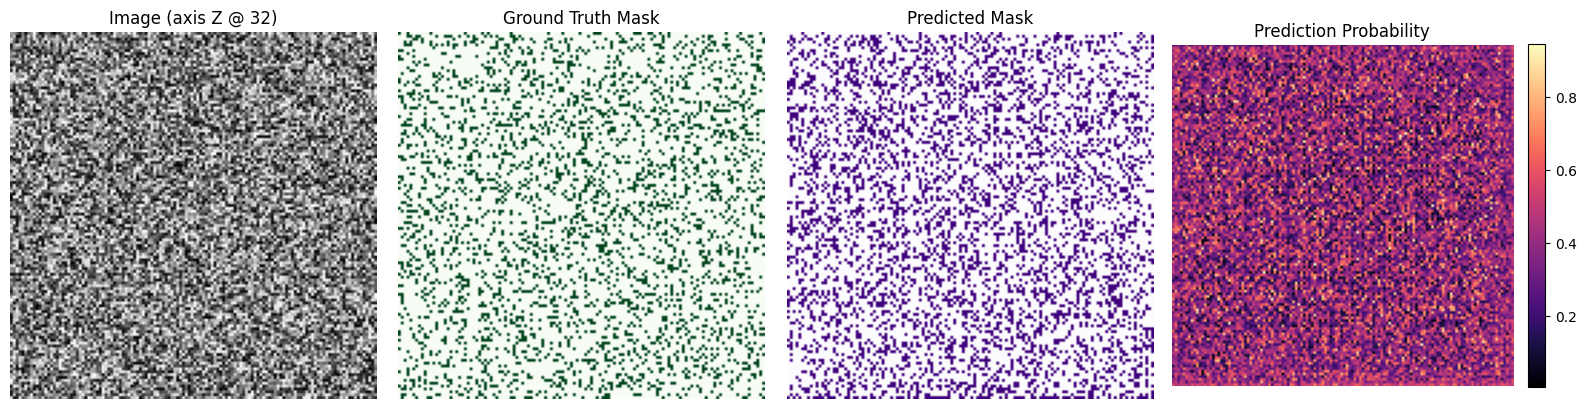

In [52]:
VISUALIZE_SAMPLE = True
SAMPLE_INDEX = 1
SLICE_AXIS = "z"
SLICE_INDEX = 32  # Fixed slice for reproducibility

if VISUALIZE_SAMPLE:
    dataset_for_vis = val_ds if len(val_ds) > 0 else train_ds
    if len(dataset_for_vis) == 0:
        raise ValueError("Both training and validation datasets are empty; nothing to visualize.")

    def build_visualization_predictor():
        bagging = globals().get("bagging_models", [])
        boosting = globals().get("boosting_models", [])
        boosting_alphas = globals().get("boosting_alphas")
        meta_model = globals().get("meta_model")

        if bagging and meta_model is not None:
            print("Using stacking ensemble for visualization.")
            return lambda imgs: stacking_inference(bagging, meta_model, imgs)
        if bagging:
            print("Using bagging ensemble for visualization.")
            return lambda imgs: bagging_inference(bagging, imgs)
        if boosting and boosting_alphas is not None:
            print("Using boosting ensemble for visualization.")
            return lambda imgs: boosting_inference(boosting, boosting_alphas, imgs)

        print("No trained ensemble available; using a randomly initialised UNet for visualization.")
        fallback_model = create_unet(cfg)
        fallback_model.eval()

        def _fallback_predict(imgs: torch.Tensor):
            return torch.softmax(fallback_model(imgs), dim=1)

        return _fallback_predict

    predictor = build_visualization_predictor()
    fig = visualize_prediction(
        dataset=dataset_for_vis,
        predict_fn=predictor,
        sample_index=SAMPLE_INDEX,
        axis=SLICE_AXIS,
        slice_index=SLICE_INDEX,
    )
    plt.show()
else:
    print("Visualization skipped; set VISUALIZE_SAMPLE=True to enable.")

In [53]:
RUN_TRAINING = True # Set to True to launch full training once data is available

def build_evaluation_dataset(files):
    eval_transforms = Compose(
        [
            LoadVolume(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            EnsureTyped(keys=["image", "label"], dtype=torch.float32),
        ]
    )
    return CacheDataset(files, transform=eval_transforms, cache_rate=0.0)


def compute_sample_errors(model: nn.Module, files: List[Dict[str, str]]):
    eval_ds = build_evaluation_dataset(files)
    loader = DataLoader(eval_ds, batch_size=1, shuffle=False, num_workers=cfg.num_workers)
    errors = []
    metric = DiceMetric(include_background=False, reduction="mean")
    model.eval()
    with torch.no_grad():
        for batch_data in loader:
            images = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            with torch.cuda.amp.autocast(enabled=cfg.amp):
                outputs = model(images)
            data = {"pred": outputs, "label": labels}
            data_list = [post_trans(i) for i in decollate_batch(data)]
            sample_dice = metric(data_list[0]["pred"], data_list[0]["label"]).item()
            errors.append(1.0 - sample_dice)
            metric.reset()
    return np.array(errors)

## 2. Next steps

1. Download the pre-processed ISLES'22 dataset from Google Drive into the directory referenced by `cfg.data_root`.
2. Verify GPU availability and adjust `cfg.batch_size`, `cfg.roi_size`, and `cfg.cache_rate` to fit memory constraints.
3. Set `RUN_TRAINING = True` in the control cell and execute the notebook sequentially.
4. Monitor the TensorBoard logs under `runs/` for loss curves and metrics.
5. Optionally persist trained weights and ensemble metadata (alphas, logistic regression coefficients) for inference.
